<table class="table table-bordered">
    <tr>
        <th style="width:200px;">
            <img src='https://bcgriseacademy.com/hs-fs/hubfs/RISE%202.0%20Logo_Options_25Jan23_RISE%20-%20For%20Black%20Background.png?width=3522&height=1986&name=RISE%202.0%20Logo_Options_25Jan23_RISE%20-%20For%20Black%20Background.png' style="background-color:black; width: 100%; height: 100%;">
        </th>
        <th style="text-align:center;">
            <h1>IBF TFIP</h1>
            <h2>Time Series Modelling</h2>
        </th>
    </tr>
</table>

### Tasks ###

1. Import all the required libraries deemed necessary to perform forecasting.
2. Read the data 'data_Inv_level.csv'.
3. Perform Exploratory Data Analysis and plot the data to check for any outliers or skewness
4. Choose an appropriate method to treat the outliers identifiers in previous task.
5. Perform log transformation of the quantity column (y).
6. Drop the existing column y and rename the new log transformed column to y.
7. Write a function to check stationarity of each SKU in the data.
8. For all the stationary SKUs identified, run the Prophet model to make forecast for the next 3 months.
9. Check if the forecasting is reasonable using appropriate metrics.
9. Visualize the forecasted output for each SKU and check if the forecasting is reasonable.
10. Perform an anti-log conversion for the forecasted values.
11. For the non stationary SKUs, perform a first order differencing and check if they are stationary after the operation.
12. Run the Prophet model to make forecast for all these SKUs for the next 3 months.
13. Check if the forecasting is reasonable using appropriate metrics.
14. Visualize the forecasted output for each SKU and check if the forecasting is reasonable.
15. Perform an anti-log conversion for the forecasted values.

**1. Importing the libraries**

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
from scipy.stats import variation
from statsmodels.tsa.stattools import adfuller
import sklearn
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from math import sqrt
%matplotlib inline
warnings.filterwarnings('ignore')

**2. Reading the data**

In [2]:
data= pd.read_csv('./data/data_Inv_level.csv')

In [3]:
data.head()

,ds,Inventory Code,y
0,1/7/2022,1030,2964.0
1,1/7/2022,1031,904.8
2,1/7/2022,1032,1731.6
3,1/7/2022,1033,1513.2
4,1/7/2022,1034,1014.0


**3. Plotting the data to check skewness and outliers**

INVENTORY CODE: 1030


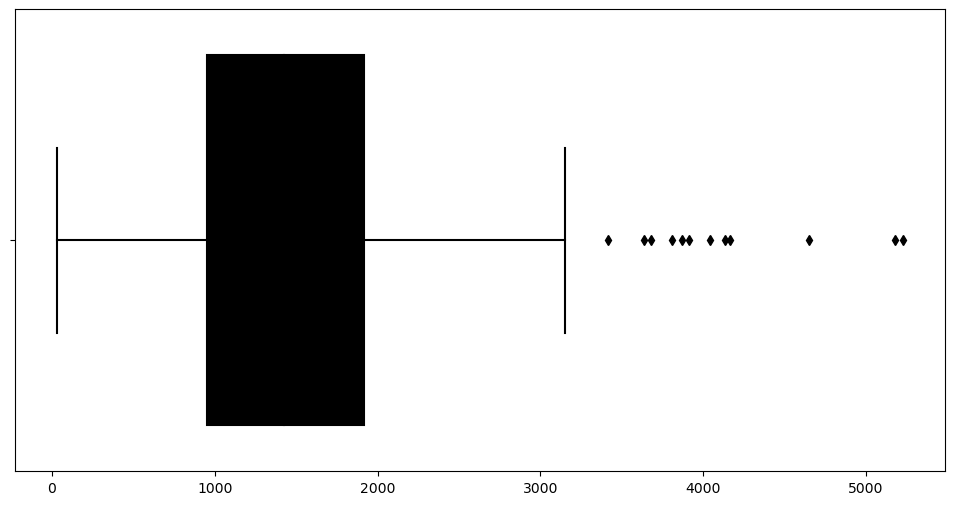

INVENTORY CODE: 1031


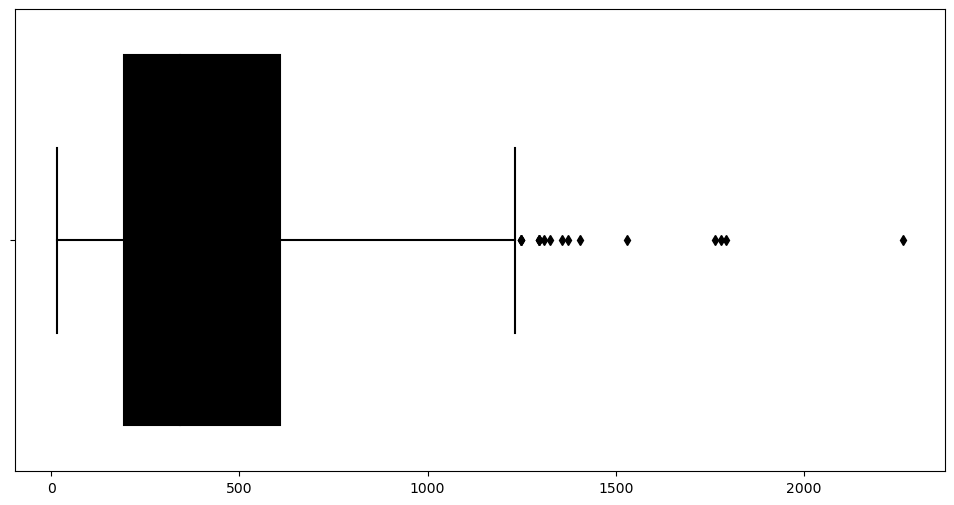

INVENTORY CODE: 1032


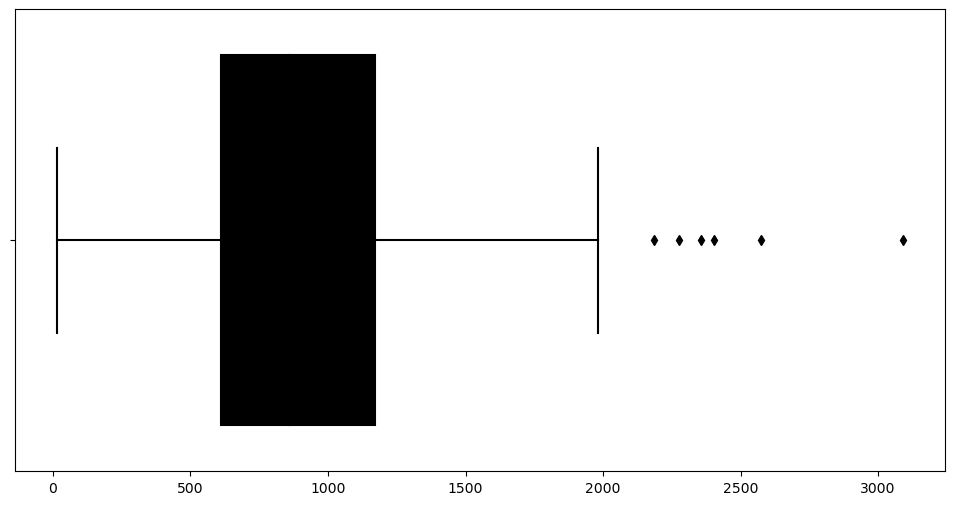

INVENTORY CODE: 1033


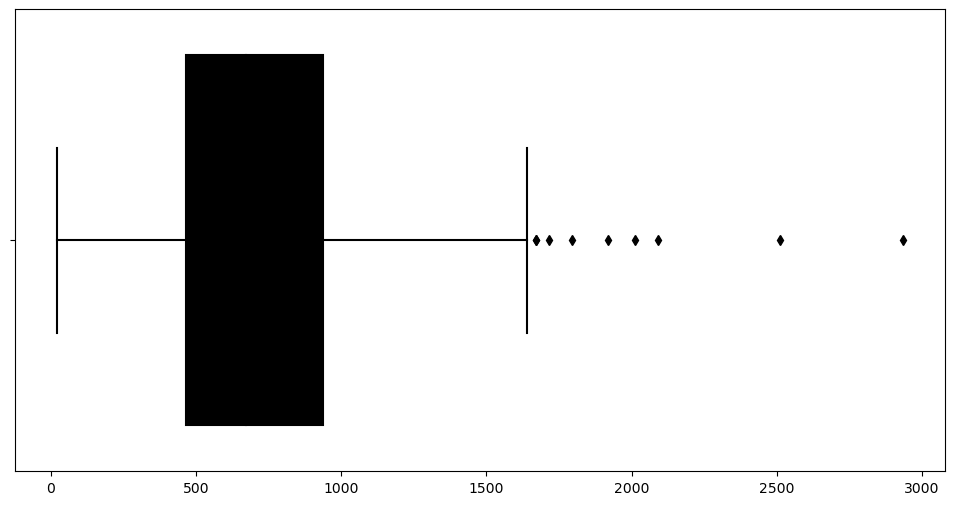

INVENTORY CODE: 1034


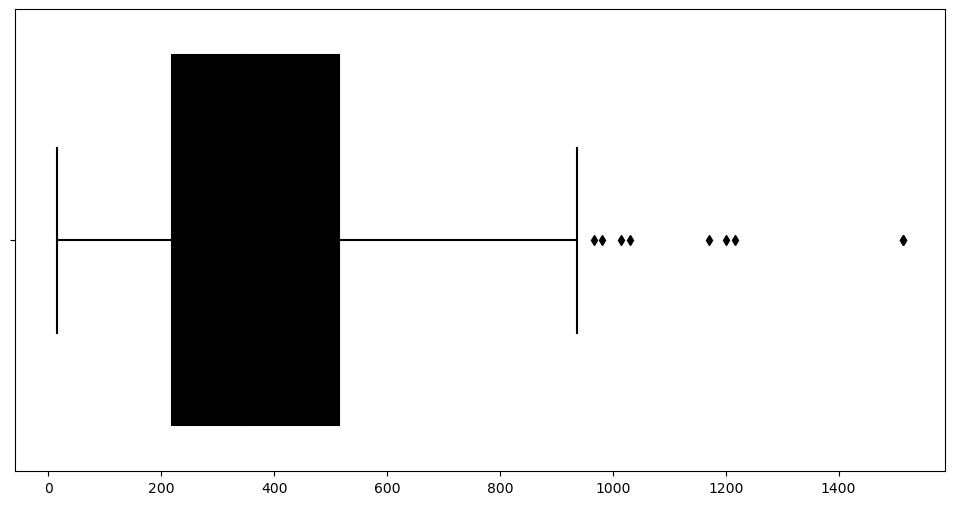

INVENTORY CODE: 1035


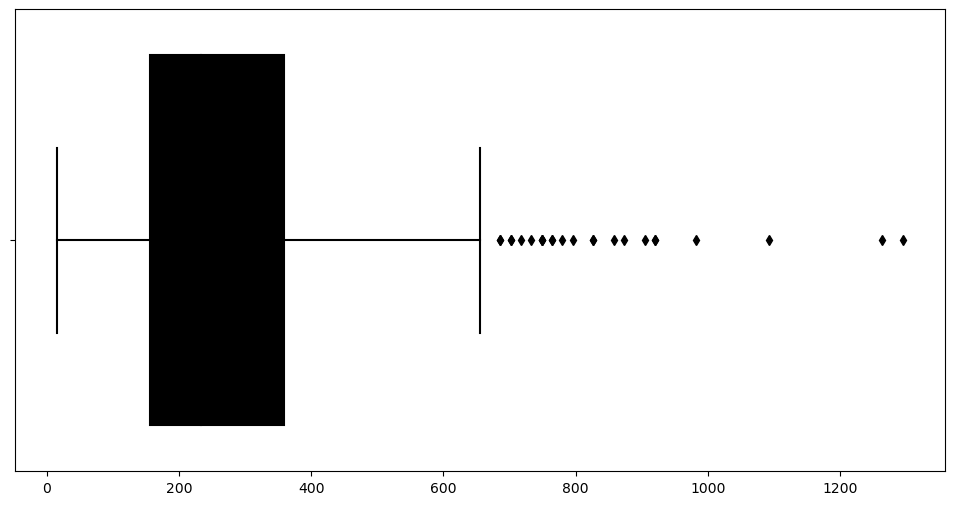

INVENTORY CODE: 1036


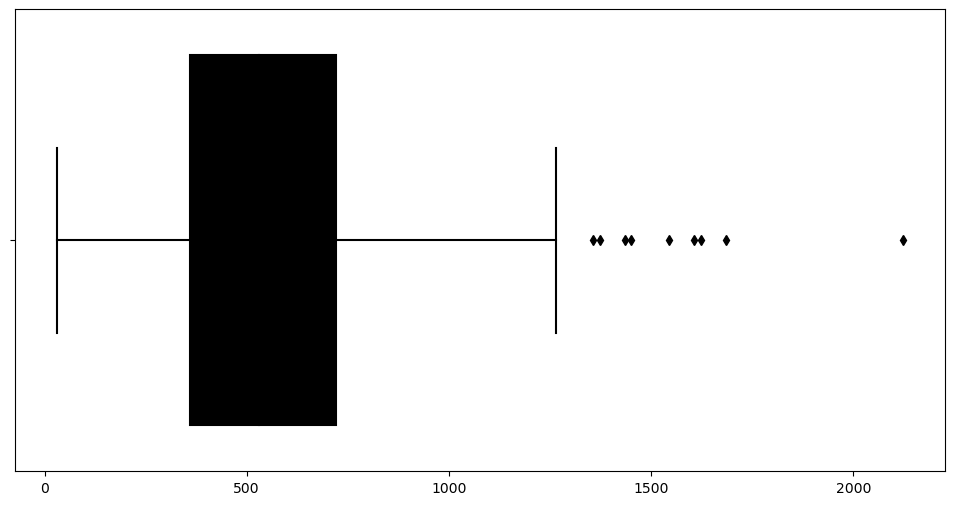

INVENTORY CODE: 1037


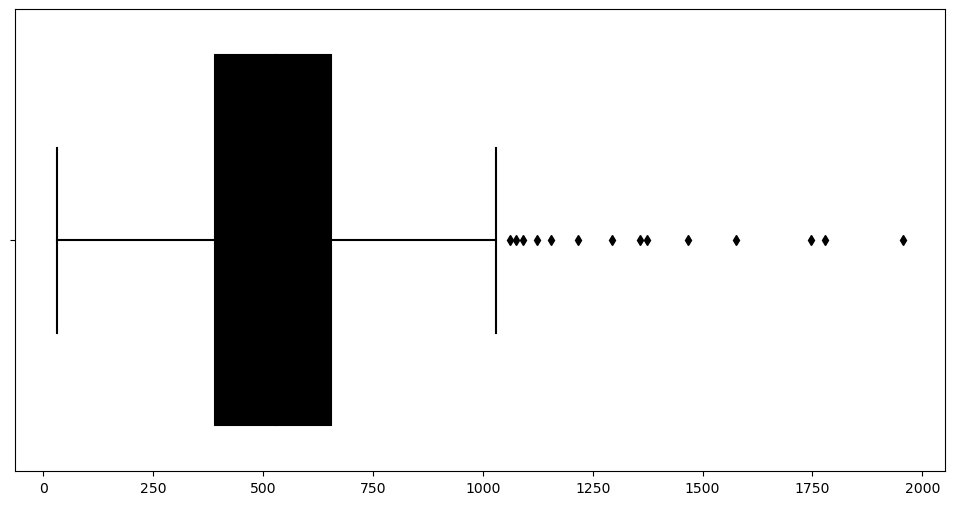

INVENTORY CODE: 1126


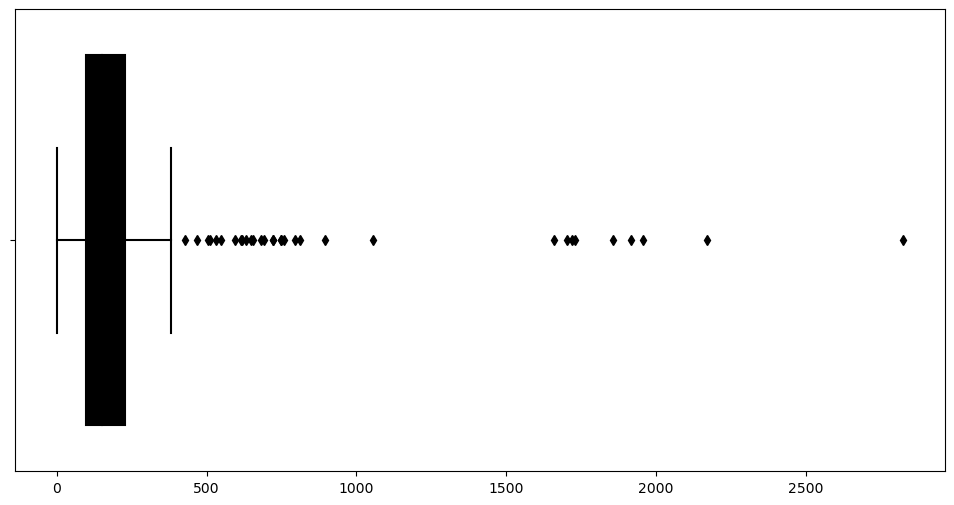

INVENTORY CODE: 1142


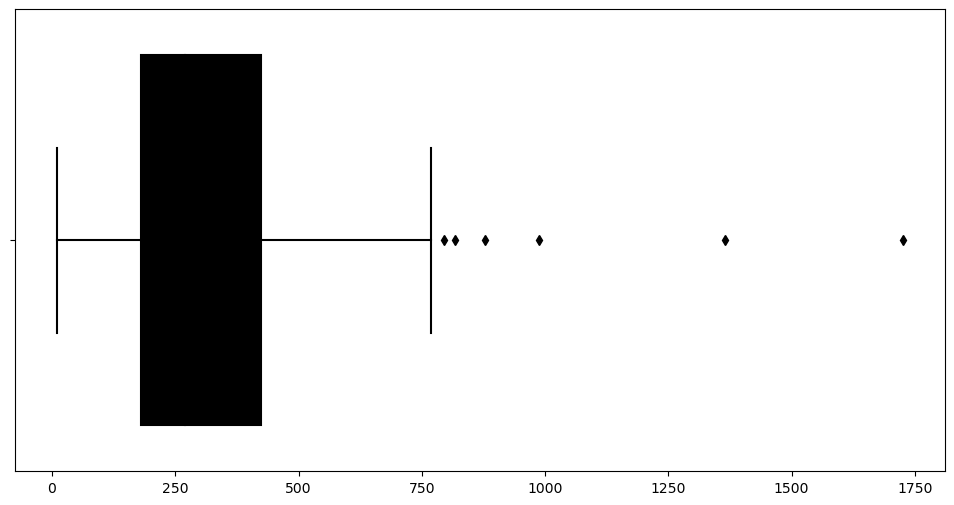

INVENTORY CODE: 1151


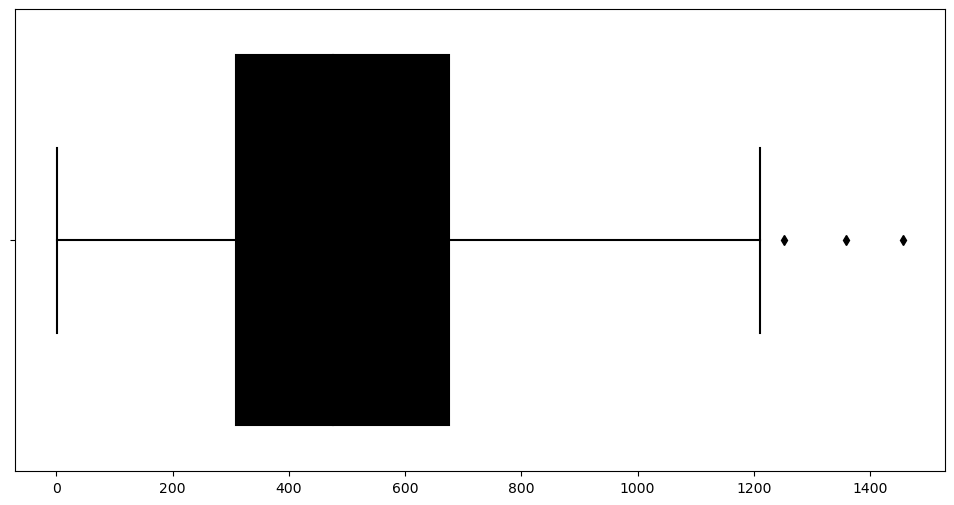

INVENTORY CODE: 1157


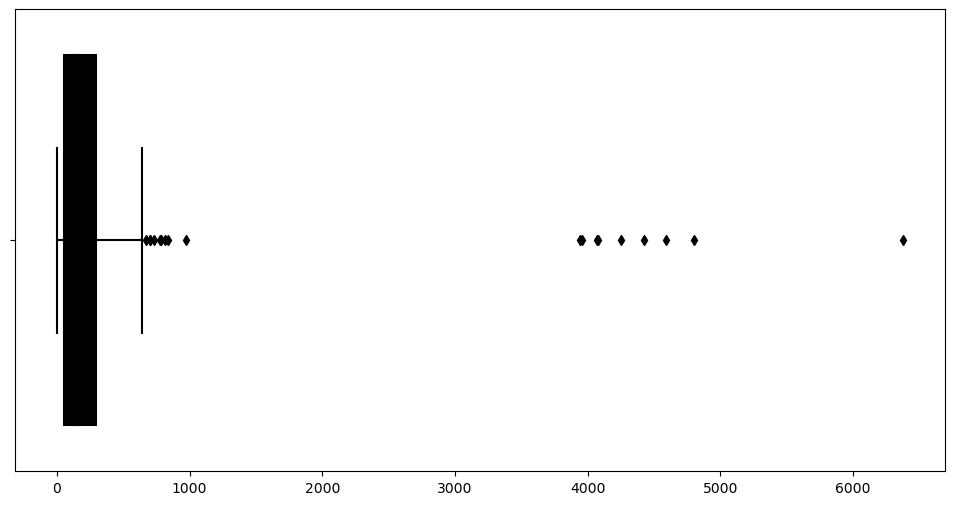

INVENTORY CODE: 1158


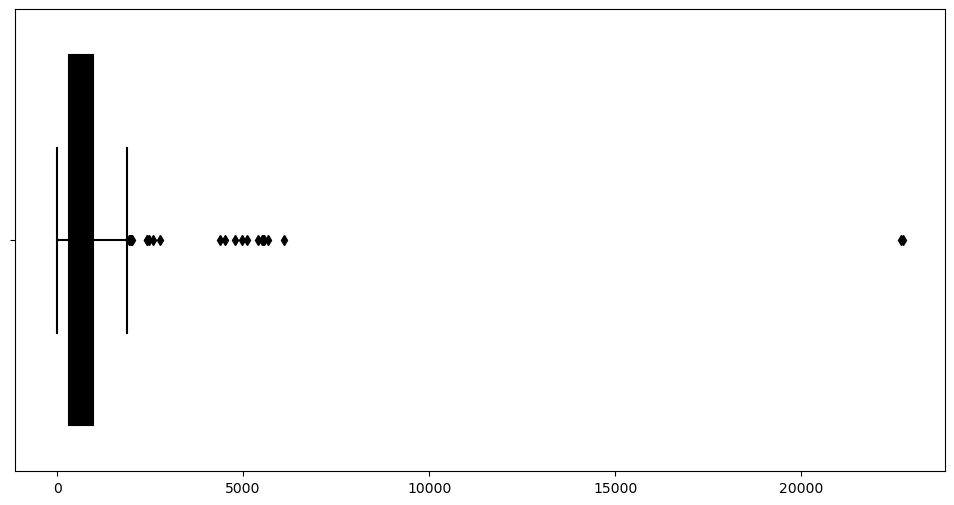

INVENTORY CODE: 1162


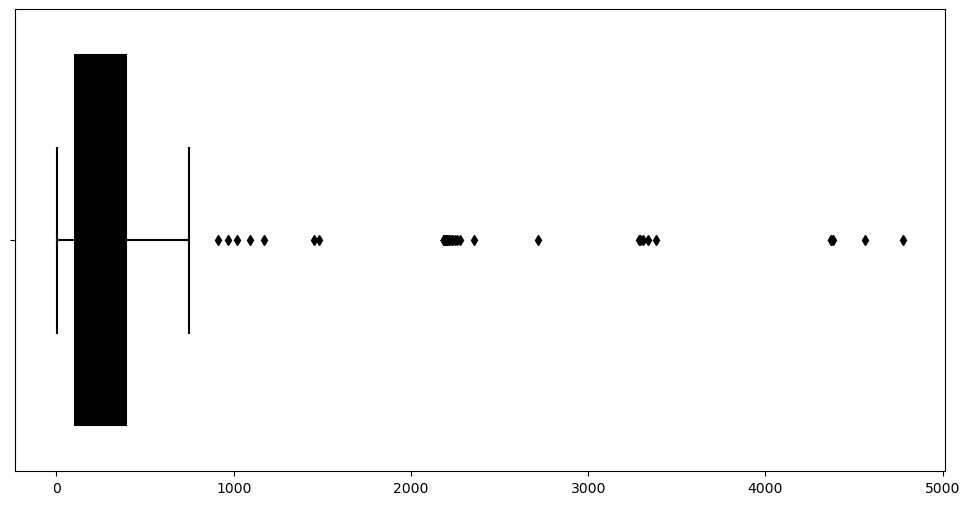

INVENTORY CODE: 1173


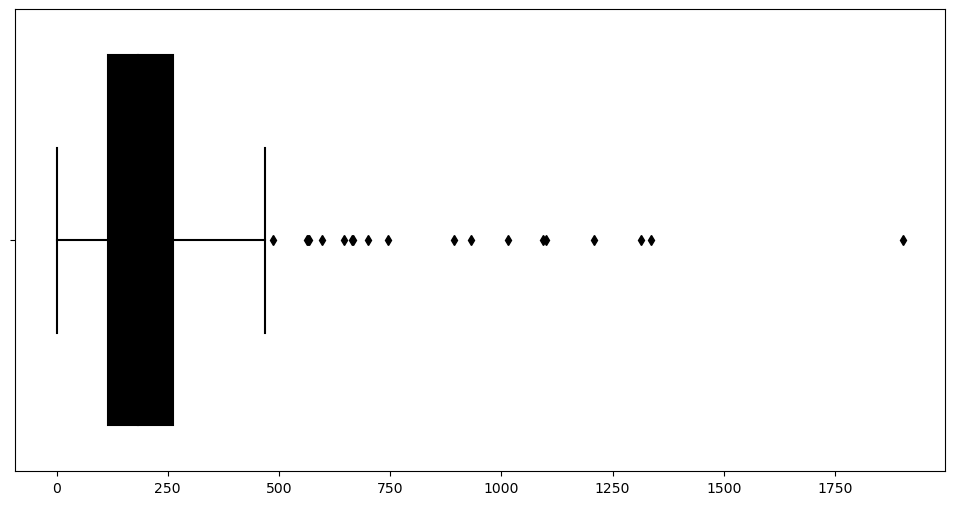

INVENTORY CODE: 1331


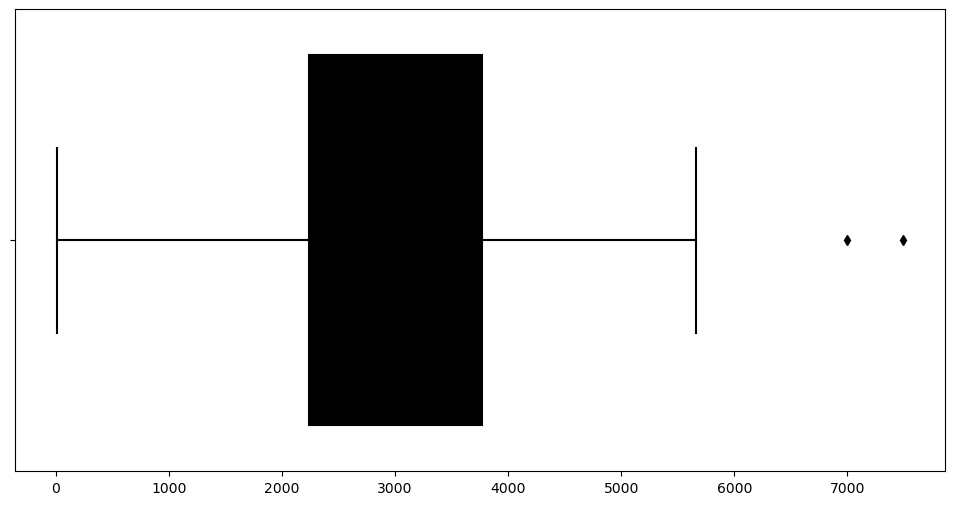

INVENTORY CODE: 1332


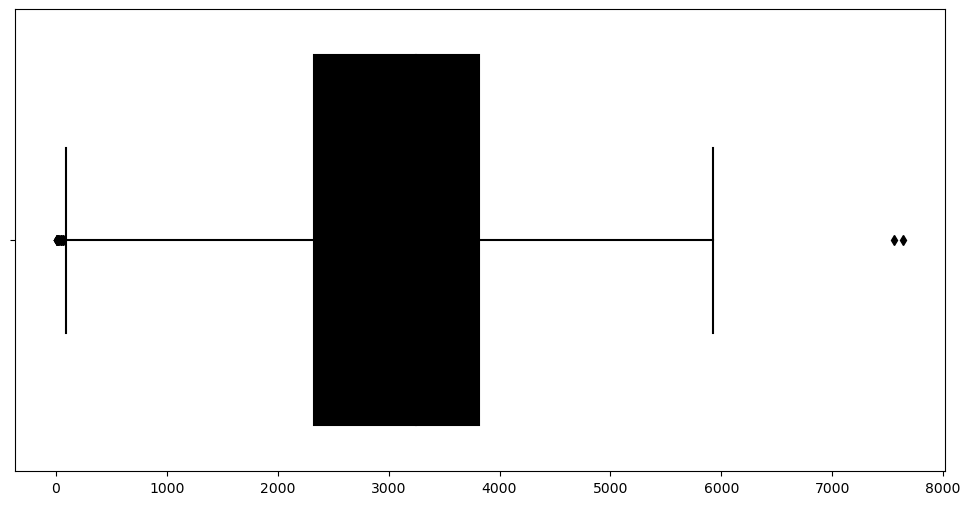

INVENTORY CODE: 1333


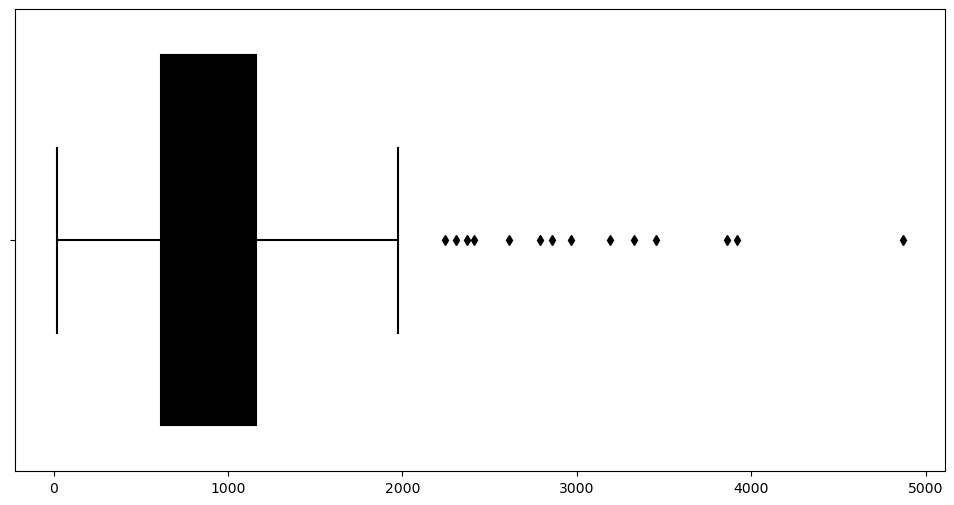

INVENTORY CODE: Others


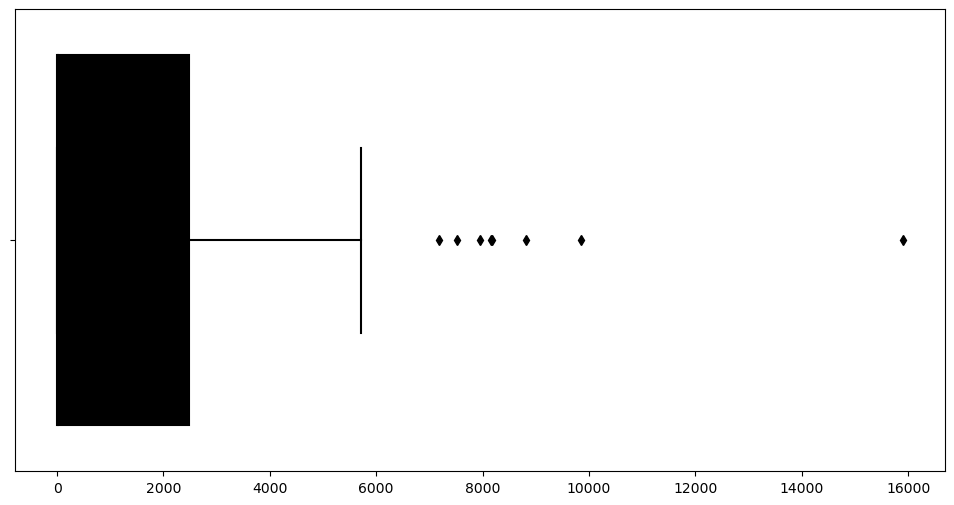

INVENTORY CODE: 1330


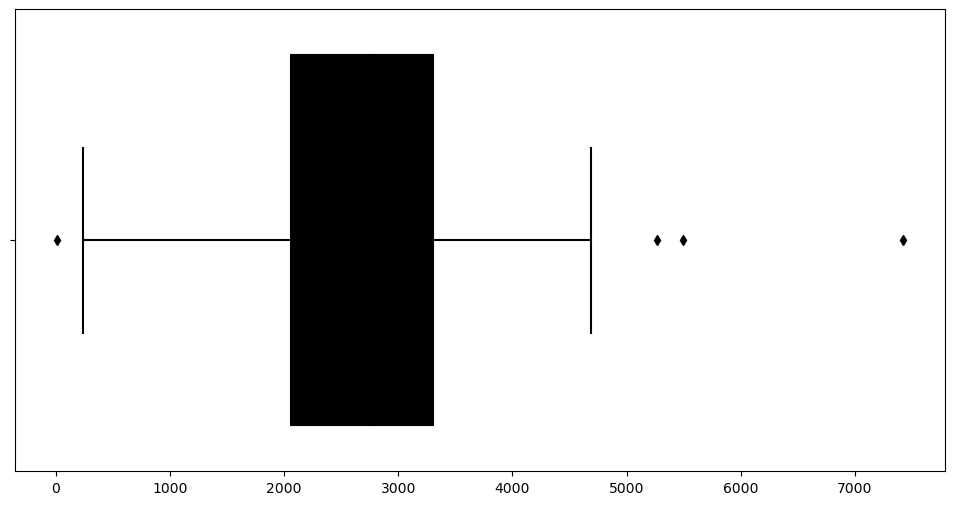

In [4]:
#Plotting for Outliers
for product in data['Inventory Code'].unique():
    df=data[data['Inventory Code']==product]
    y_true = df['y'].values
    plt.figure(figsize=(12,6))
    sns.boxplot(y_true, color='black')
    print(f"INVENTORY CODE: {product}")
    plt.show()

**4. Outlier Treatment**

In [5]:
# Treating the Outliers
A = []

for product in data["Inventory Code"].unique():
    temp = data[data["Inventory Code"]==product]
    upper_limit = np.percentile(temp["y"], 90)
    temp.loc[temp["y"]>upper_limit,"y"] = upper_limit
    lower_limit = np.percentile(temp["y"], 10)
    temp.loc[temp["y"]<lower_limit,"y"] = lower_limit
    A.append(temp)
    
data = pd.concat(A)
data.head()



,ds,Inventory Code,y
0,1/7/2022,1030,2792.4
18,2/7/2022,1030,655.2
33,4/7/2022,1030,2246.4
51,5/7/2022,1030,655.2
68,6/7/2022,1030,2792.4


In [6]:
col_to_indexing=['y']

**5. Logarithmic Transformation**

In [7]:
# Creating and taking log of the relevant numeric cols
for col in col_to_indexing:
    data["LN_" + col] = np.log(data[col])

In [8]:
data.head()

,ds,Inventory Code,y,LN_y
0,1/7/2022,1030,2792.4,7.934657
18,2/7/2022,1030,655.2,6.484941
33,4/7/2022,1030,2246.4,7.717084
51,5/7/2022,1030,655.2,6.484941
68,6/7/2022,1030,2792.4,7.934657


In [9]:
data_org=data.copy()

**6. Column name change for the log quantity column**

In [10]:
data.drop('y', axis=1, inplace=True)
data=data.rename(columns={'LN_y':'y'})

**7. Checking for Stationarity in the data for each SKU**

In [11]:
# Function to check stationarity using Augmented Dickey-Fuller test
def check_stationarity(data):
    result = adfuller(data)
    p_value = result[1]
    return p_value

# Define the products to check stationarity for
products_to_check = data['Inventory Code'].unique()

# Create a dataframe to store the results
#results = pd.DataFrame(columns=['Product', 'Stationary', 'P-Value'])

# Loop through each product and check stationarity
for product in products_to_check:
    product_data = data.loc[data['Inventory Code'] == product, 'y']
    p_value = check_stationarity(product_data)
    #is_stationary = p_value <= 0.05
    #results = results.append({'Product': product, 'Stationary': is_stationary, 'P-Value': p_value}, ignore_index=True)
    if p_value > 0.05:
        print(f"{product} is not stationary")
    else:
        print(f"{product} is stationary")

1030 is stationary
1031 is not stationary
1032 is stationary
1033 is stationary
1034 is stationary
1035 is not stationary
1036 is not stationary
1037 is stationary
1126 is stationary
1142 is stationary
1151 is stationary
1157 is stationary
1158 is stationary
1162 is stationary
1173 is stationary
1331 is not stationary
1332 is not stationary
1333 is not stationary
Others is stationary
1330 is not stationary


In [12]:
# Stationary product list
product_list = ['1030', '1032', '1033', '1034', '1037', '1126', '1142', '1151', '1157', '1158', '1162', '1173', 'Others']

Grouping the data by Inventory Code

In [13]:
# Group the data by Inventory Code
groups_by_product = data.groupby('Inventory Code')
# Check the groups in the dataframe
groups_by_product.groups.keys()

dict_keys(['1030', '1031', '1032', '1033', '1034', '1035', '1036', '1037', '1126', '1142', '1151', '1157', '1158', '1162', '1173', '1330', '1331', '1332', '1333', 'Others'])

**8. Creating a function to run Prophet model**

In [14]:
# Create a function for the prophet model
def train_and_forecast(group):
  # Initiate the model
  m = Prophet(interval_width=0.95, daily_seasonality=True)
 
 #train & test Split
  # Sort the dataframe by 'Date' in ascending order
  group = group.sort_values('ds')

  # Calculate the index to split the data
  split_index = int(len(group) * 0.8)

  # Split the data into train and test sets
  train_data = group[:split_index]
  test_data = group[split_index:]
  
  # Fit the model
  m.fit(train_data)
  # Make predictions
  future = m.make_future_dataframe(periods=180, freq='D')
  forecast = m.predict(future)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
  forecast['Inventory Code'] = train_data['Inventory Code'].iloc[0]
  #plot1 =m.plot(group)
  
  # Return the forecasted results
  return forecast[['ds', 'Inventory Code', 'yhat', 'yhat_upper', 'yhat_lower']]

Prophet model run

In [15]:
# Start time
#start_time = time()
# Create an empty dataframe
for_loop_forecast = pd.DataFrame()
# Loop through each product
for product in product_list:
  # Get the data for the stationary products
  group = groups_by_product.get_group(product)  
  # Make forecast
  forecast = train_and_forecast(group)
  # Add the forecast results to the dataframe
  for_loop_forecast = pd.concat((for_loop_forecast, forecast))
#print('The time used for the for-loop forecast is ', time()-start_time)
# Take a look at the data
for_loop_forecast.head()

11:29:06 - cmdstanpy - INFO - Chain [1] start processing
11:29:06 - cmdstanpy - INFO - Chain [1] done processing
11:29:06 - cmdstanpy - INFO - Chain [1] start processing
11:29:06 - cmdstanpy - INFO - Chain [1] done processing
11:29:06 - cmdstanpy - INFO - Chain [1] start processing
11:29:07 - cmdstanpy - INFO - Chain [1] done processing
11:29:07 - cmdstanpy - INFO - Chain [1] start processing
11:29:07 - cmdstanpy - INFO - Chain [1] done processing
11:29:07 - cmdstanpy - INFO - Chain [1] start processing
11:29:07 - cmdstanpy - INFO - Chain [1] done processing
11:29:07 - cmdstanpy - INFO - Chain [1] start processing
11:29:07 - cmdstanpy - INFO - Chain [1] done processing
11:29:07 - cmdstanpy - INFO - Chain [1] start processing
11:29:07 - cmdstanpy - INFO - Chain [1] done processing
11:29:08 - cmdstanpy - INFO - Chain [1] start processing
11:29:08 - cmdstanpy - INFO - Chain [1] done processing
11:29:08 - cmdstanpy - INFO - Chain [1] start processing
11:29:08 - cmdstanpy - INFO - Chain [1]

,ds,Inventory Code,yhat,yhat_upper,yhat_lower
0,2022-01-07,1030,7.413828,8.195394,6.590359
1,2022-01-08,1030,7.212902,8.040029,6.385907
2,2022-01-09,1030,7.223988,8.189162,6.376939
3,2022-01-10,1030,7.120650,7.928045,6.305501
4,2022-01-11,1030,7.250722,8.123056,6.470954


**9. Check metrics**

**10. plotting the results for each Inventory Code**

INVENTORY CODE: 1030
ROOT MEAN SQUARED ERROR: 0.49521849838008647


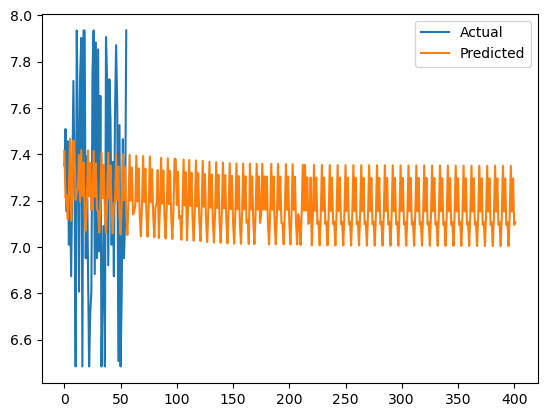

<Figure size 3000x1500 with 0 Axes>

INVENTORY CODE: 1032
ROOT MEAN SQUARED ERROR: 0.4393115517213607


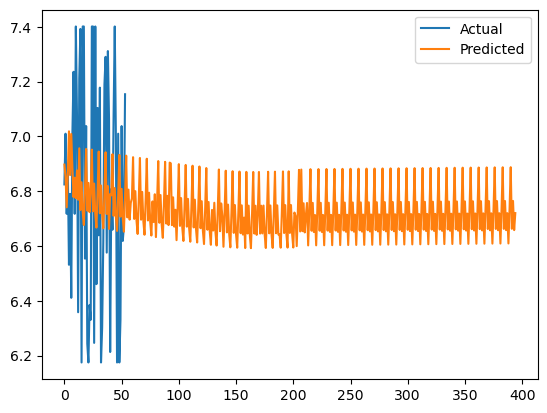

<Figure size 3000x1500 with 0 Axes>

INVENTORY CODE: 1033
ROOT MEAN SQUARED ERROR: 0.5713835897388961


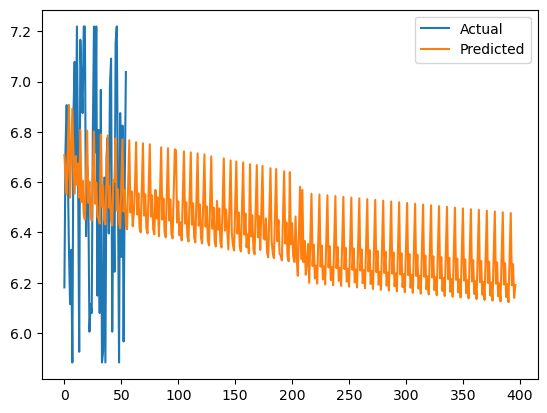

<Figure size 3000x1500 with 0 Axes>

INVENTORY CODE: 1034
ROOT MEAN SQUARED ERROR: 0.5733561997900062


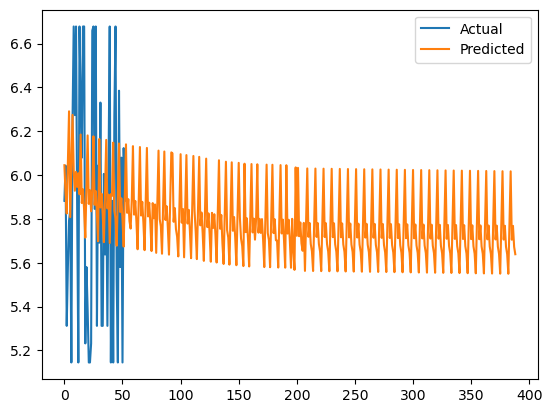

<Figure size 3000x1500 with 0 Axes>

INVENTORY CODE: 1037
ROOT MEAN SQUARED ERROR: 0.32024954781005593


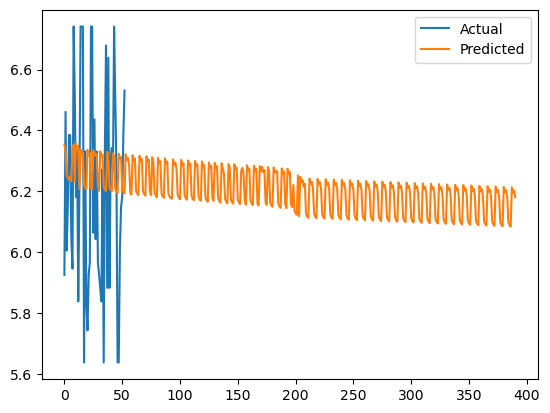

<Figure size 3000x1500 with 0 Axes>

INVENTORY CODE: 1126
ROOT MEAN SQUARED ERROR: 0.6118059854530303


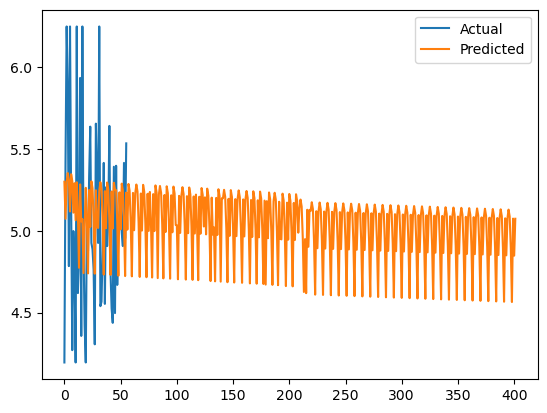

<Figure size 3000x1500 with 0 Axes>

INVENTORY CODE: 1142
ROOT MEAN SQUARED ERROR: 0.6333245066874978


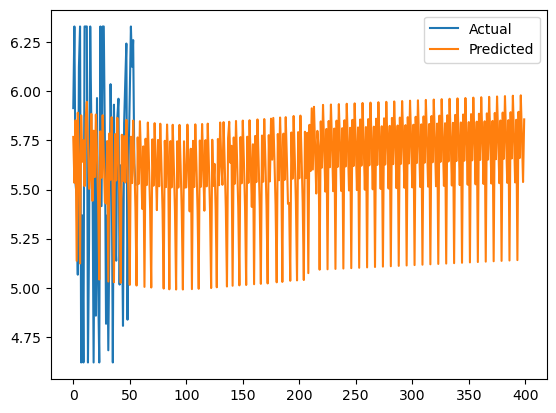

<Figure size 3000x1500 with 0 Axes>

INVENTORY CODE: 1151
ROOT MEAN SQUARED ERROR: 0.5356844601009797


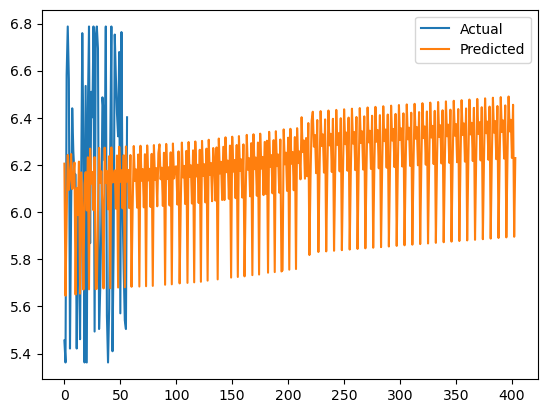

<Figure size 3000x1500 with 0 Axes>

INVENTORY CODE: 1157
ROOT MEAN SQUARED ERROR: 1.0814162331507076


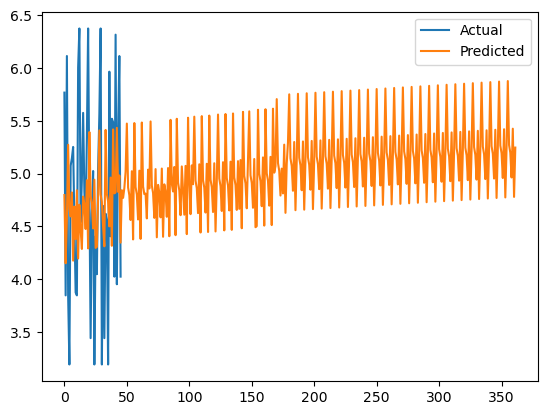

<Figure size 3000x1500 with 0 Axes>

INVENTORY CODE: 1158
ROOT MEAN SQUARED ERROR: 0.7293513197317114


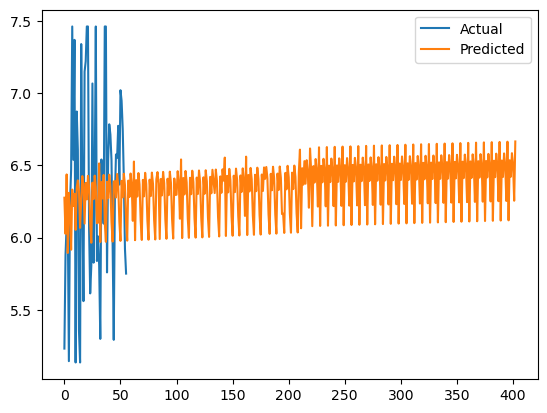

<Figure size 3000x1500 with 0 Axes>

INVENTORY CODE: 1162
ROOT MEAN SQUARED ERROR: 1.488753493020826


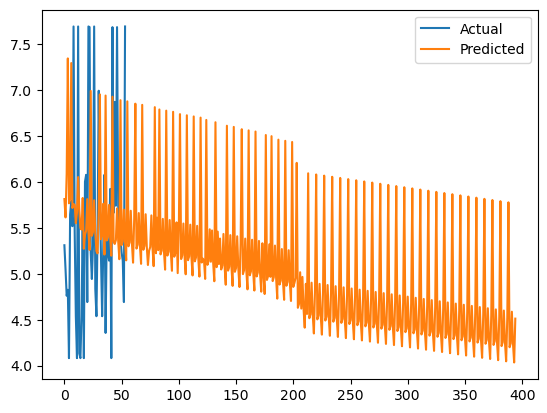

<Figure size 3000x1500 with 0 Axes>

INVENTORY CODE: 1173
ROOT MEAN SQUARED ERROR: 0.5527902645781781


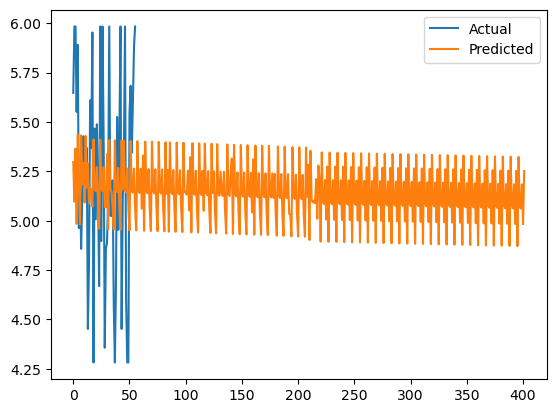

<Figure size 3000x1500 with 0 Axes>

INVENTORY CODE: Others
ROOT MEAN SQUARED ERROR: 4.694132265728829


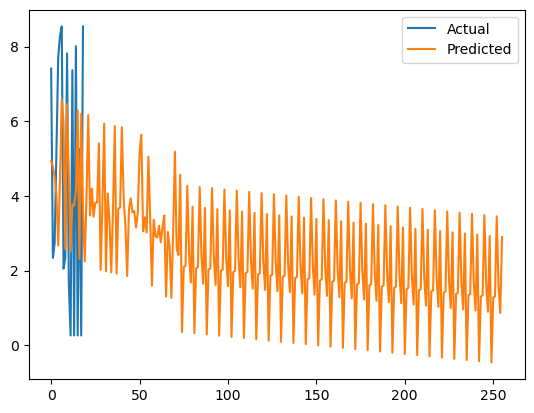

<Figure size 3000x1500 with 0 Axes>

In [16]:
# plot expected vs actual
for product in product_list:
    frame=for_loop_forecast[for_loop_forecast['Inventory Code']==product]
    frame = frame.sort_values('ds')
    y_pred = frame['yhat'].values

    
    original_df=data[data['Inventory Code']==product]
    original_df = original_df.sort_values('ds')

    # Calculate the index to split the data
    split_index = int(len(original_df) * 0.8)

    # Split the data into train and test sets
    train_data = original_df[:split_index]
    test_data = original_df[split_index:]
  
    y_test = test_data['y'].values

    # calculate RMSE
    rmse=sqrt(mean_squared_error(y_test, y_pred[-len(test_data):])) 
    
    from matplotlib import pyplot
    pyplot.plot(y_test, label='Actual')
    pyplot.plot(y_pred, label='Predicted')
    pyplot.legend()
    pyplot.figure(figsize=(30,15))
    print(f"INVENTORY CODE: {product}")
    print(f"ROOT MEAN SQUARED ERROR: {rmse}")
    pyplot.show()

In [17]:
for_loop_forecast.head()

,ds,Inventory Code,yhat,yhat_upper,yhat_lower
0,2022-01-07,1030,7.413828,8.195394,6.590359
1,2022-01-08,1030,7.212902,8.040029,6.385907
2,2022-01-09,1030,7.223988,8.189162,6.376939
3,2022-01-10,1030,7.120650,7.928045,6.305501
4,2022-01-11,1030,7.250722,8.123056,6.470954


**11. Anti-log transformation for forecasted values**

In [18]:
for_loop_forecast['yhat_exp']=np.exp(for_loop_forecast['yhat'])

In [20]:
data.head()

,ds,Inventory Code,y
0,1/7/2022,1030,7.934657
18,2/7/2022,1030,6.484941
33,4/7/2022,1030,7.717084
51,5/7/2022,1030,6.484941
68,6/7/2022,1030,7.934657


**12. Non-Stationary data Predictions - Perform First Order Differencing**

In [21]:
data = data.sort_values(by=['ds', 'Inventory Code'], ascending=True)

In [22]:
# first differencing

data['y_diff']=data.groupby('Inventory Code')['y'].diff()
data['y_diff']=data.groupby('Inventory Code')['y_diff'].fillna(data['y']).ffill()
data=data.drop(['y'], axis=1)
data=data.rename(columns={'y_diff':'y'})

Checking Stationarity after First differencing for the Non-Stationary Inventory Codes

In [23]:
# Function to check stationarity using Augmented Dickey-Fuller test
def check_stationarity(data):
    result = adfuller(data)
    p_value = result[1]
    return p_value

# Define the products to check stationarity for
products_to_check = data['Inventory Code'].unique()

# Create a dataframe to store the results
#results = pd.DataFrame(columns=['Product', 'Stationary', 'P-Value'])

# Loop through each product and check stationarity
for product in products_to_check:
    product_data = data.loc[data['Inventory Code'] == product, 'y']
    p_value = check_stationarity(product_data)
    #is_stationary = p_value <= 0.05
    #results = results.append({'Product': product, 'Stationary': is_stationary, 'P-Value': p_value}, ignore_index=True)
    if p_value > 0.05:
        print(f"{product} is not stationary")
    else:
        print(f"{product} is stationary")

1030 is stationary
1031 is stationary
1032 is stationary
1033 is stationary
1034 is stationary
1035 is stationary
1036 is stationary
1037 is stationary
1126 is stationary
1142 is stationary
1151 is stationary
1158 is stationary
1162 is stationary
1173 is stationary
1331 is stationary
1332 is stationary
1330 is stationary
1333 is stationary
1157 is stationary
Others is stationary


In [24]:
# Non-Stationary Product list
ns_product_list = ['1031', '1035', '1036', '1331', '1332', '1333', '1330']

In [25]:
# Group the data by Inventory Code
groups_by_product = data.groupby('Inventory Code')
# Check the groups in the dataframe
groups_by_product.groups.keys()

dict_keys(['1030', '1031', '1032', '1033', '1034', '1035', '1036', '1037', '1126', '1142', '1151', '1157', '1158', '1162', '1173', '1330', '1331', '1332', '1333', 'Others'])

**13. Run Prophet model**

In [26]:
# Create a function for the prophet model
def train_and_forecast(group):
  # Initiate the model
  m = Prophet(interval_width=0.95, daily_seasonality=True)
 
 #train & test Split
  # Sort the dataframe by 'Date' in ascending order
  group = group.sort_values('ds')

  # Calculate the index to split the data
  split_index = int(len(group) * 0.8)

  # Split the data into train and test sets
  train_data = group[:split_index]
  test_data = group[split_index:]
  
  # Fit the model
  m.fit(train_data)
  # Make predictions
  future = m.make_future_dataframe(periods=90, freq='D')
  forecast = m.predict(future)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
  forecast['Inventory Code'] = train_data['Inventory Code'].iloc[0]
  #plot1 =m.plot(group)
  
  # Return the forecasted results
  return forecast[['ds', 'Inventory Code', 'yhat', 'yhat_upper', 'yhat_lower']]

In [27]:
# Start time
#start_time = time()
# Create an empty dataframe
for_loop_forecast = pd.DataFrame()
# Loop through each product
for product in ns_product_list:
  # Get the data for the stationary products
  group = groups_by_product.get_group(product)  
  # Make forecast
  forecast = train_and_forecast(group)
  # Add the forecast results to the dataframe
  for_loop_forecast = pd.concat((for_loop_forecast, forecast))
#print('The time used for the for-loop forecast is ', time()-start_time)
# Take a look at the data
for_loop_forecast.head()

11:29:15 - cmdstanpy - INFO - Chain [1] start processing
11:29:15 - cmdstanpy - INFO - Chain [1] done processing
11:29:16 - cmdstanpy - INFO - Chain [1] start processing
11:29:16 - cmdstanpy - INFO - Chain [1] done processing
11:29:16 - cmdstanpy - INFO - Chain [1] start processing
11:29:16 - cmdstanpy - INFO - Chain [1] done processing
11:29:16 - cmdstanpy - INFO - Chain [1] start processing
11:29:16 - cmdstanpy - INFO - Chain [1] done processing
11:29:16 - cmdstanpy - INFO - Chain [1] start processing
11:29:16 - cmdstanpy - INFO - Chain [1] done processing
11:29:16 - cmdstanpy - INFO - Chain [1] start processing
11:29:16 - cmdstanpy - INFO - Chain [1] done processing
11:29:17 - cmdstanpy - INFO - Chain [1] start processing
11:29:17 - cmdstanpy - INFO - Chain [1] done processing


,ds,Inventory Code,yhat,yhat_upper,yhat_lower
0,2022-01-07,1031,0.592520,2.361871,-1.056755
1,2022-01-09,1031,0.342439,2.100770,-1.503973
2,2022-01-10,1031,0.751549,2.482322,-1.083587
3,2022-01-11,1031,0.739082,2.715217,-1.118829
4,2022-01-12,1031,1.057117,2.926612,-0.696173


**14. Check metrics for forecast**

**15. Run Visualization on the predicted results**

INVENTORY CODE: 1031
ROOT MEAN SQUARED ERROR: 1.2577475911951512


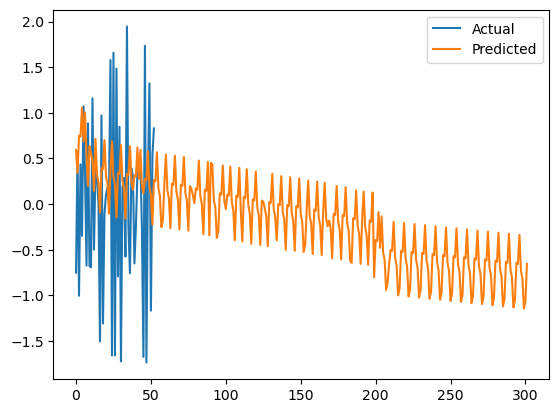

<Figure size 3000x1500 with 0 Axes>

INVENTORY CODE: 1035
ROOT MEAN SQUARED ERROR: 1.1485898177179767


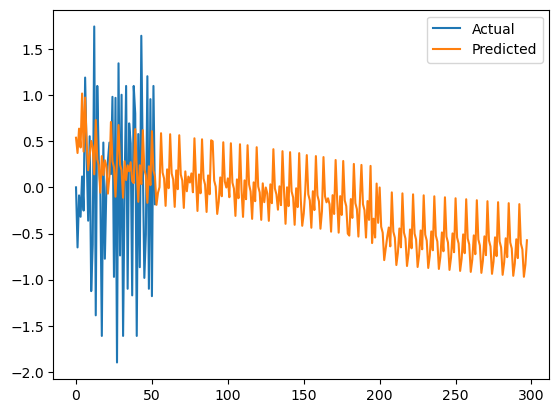

<Figure size 3000x1500 with 0 Axes>

INVENTORY CODE: 1036
ROOT MEAN SQUARED ERROR: 0.6808270277130982


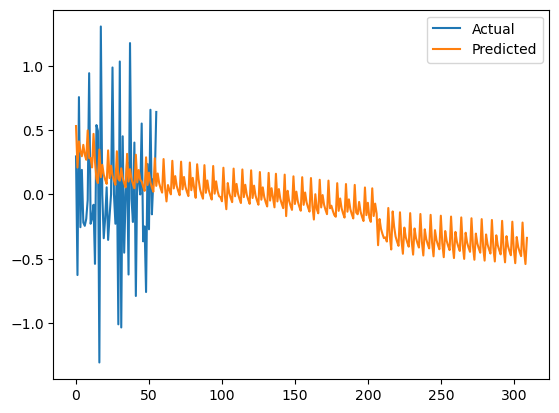

<Figure size 3000x1500 with 0 Axes>

INVENTORY CODE: 1331
ROOT MEAN SQUARED ERROR: 0.7739985344657392


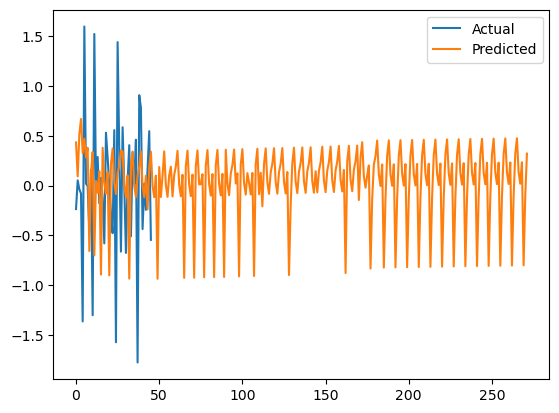

<Figure size 3000x1500 with 0 Axes>

INVENTORY CODE: 1332
ROOT MEAN SQUARED ERROR: 0.5748322698694606


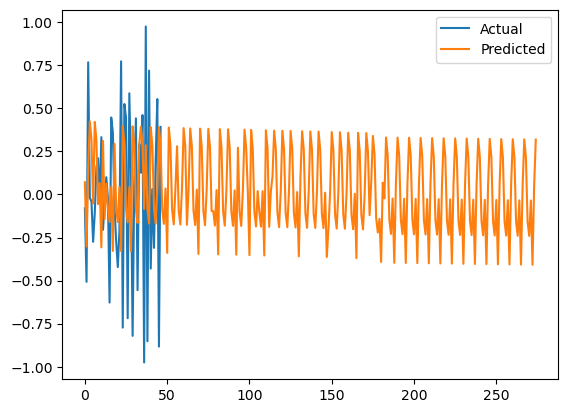

<Figure size 3000x1500 with 0 Axes>

INVENTORY CODE: 1333
ROOT MEAN SQUARED ERROR: 0.609098174390419


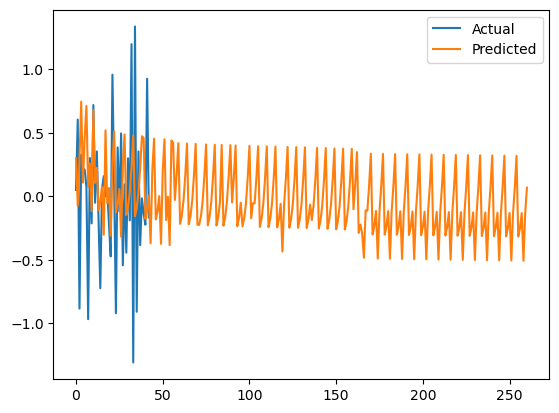

<Figure size 3000x1500 with 0 Axes>

INVENTORY CODE: 1330
ROOT MEAN SQUARED ERROR: 0.3907074422349832


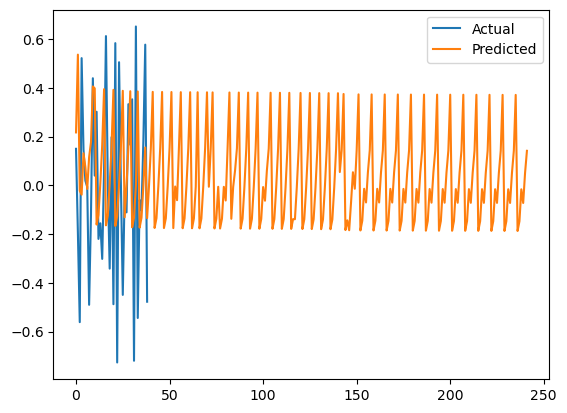

<Figure size 3000x1500 with 0 Axes>

In [29]:
# plot expected vs actual
for product in ns_product_list:
    frame=for_loop_forecast[for_loop_forecast['Inventory Code']==product]
    frame = frame.sort_values('ds')
    y_pred = frame['yhat'].values

    
    original_df=data[data['Inventory Code']==product]
    original_df = original_df.sort_values('ds')

    # Calculate the index to split the data
    split_index = int(len(original_df) * 0.8)

    # Split the data into train and test sets
    train_data = original_df[:split_index]
    test_data = original_df[split_index:]
  
    y_test = test_data['y'].values

    # calculate RMSE
    rmse=sqrt(mean_squared_error(y_test, y_pred[-len(test_data):])) 
    
    from matplotlib import pyplot
    pyplot.plot(y_test, label='Actual')
    pyplot.plot(y_pred, label='Predicted')
    pyplot.legend()
    pyplot.figure(figsize=(30,15))
    print(f"INVENTORY CODE: {product}")
    print(f"ROOT MEAN SQUARED ERROR: {rmse}")
    pyplot.show()

**16. Perform anti log transformation**

In [30]:
# Recovering data
for_loop_forecast['org_log_y']=for_loop_forecast.groupby('Inventory Code')['yhat'].cumsum()



for_loop_forecast['log_cumulative']=for_loop_forecast.groupby('Inventory Code')['org_log_y'].transform(lambda x: np.exp(x))

In [31]:
for_loop_forecast.head(10)

,ds,Inventory Code,yhat,yhat_upper,yhat_lower,org_log_y,log_cumulative
0,2022-01-07,1031,0.592520,2.361871,-1.056755,0.592520,1.808540
1,2022-01-09,1031,0.342439,2.100770,-1.503973,0.934959,2.547108
2,2022-01-10,1031,0.751549,2.482322,-1.083587,1.686508,5.400587
3,2022-01-11,1031,0.739082,2.715217,-1.118829,2.425589,11.308891
4,2022-01-12,1031,1.057117,2.926612,-0.696173,3.482706,32.547687
5,2022-02-08,1031,0.686294,2.482013,-1.064303,4.169000,64.650777
6,2022-02-09,1031,1.004329,2.701427,-0.731013,5.173329,176.501517
7,2022-02-11,1031,0.526535,2.372584,-1.205034,5.699865,298.826978
8,2022-02-12,1031,0.197783,1.979353,-1.524397,5.897648,364.179799
9,2022-03-08,1031,0.633506,2.348126,-1.145805,6.531154,686.189483


Copyright © 2023 by Boston Consulting Group. All rights reserved.